# Task 1

### Data Preprocessing
* Remove records containing missing (NA) values
* Encode categorical attributes such as Country and Status
* Normalize all numerical features

In [13]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler


def load_and_clean(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    df = df.dropna()
    return df


def encode_categorical(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    df = df.copy()
    encoder = OrdinalEncoder()
    df[columns] = encoder.fit_transform(df[columns])
    return df


def normalize_numerical(df: pd.DataFrame, exclude: list[str]) -> pd.DataFrame:
    df = df.copy()
    numerical_columns = df.columns.difference(exclude)
    scaler = MinMaxScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df


CATEGORICAL_COLUMNS = ["Country", "Status"]
TARGET_COLUMN = "Life expectancy"

raw_df = load_and_clean("Life Expectancy Data.csv")
encoded_df = encode_categorical(raw_df, CATEGORICAL_COLUMNS)
# Normalize ALL columns including ordinal-encoded Country (0–192) and Status.
# Excluding them leaves Country with std ≈ 56, which is 193× larger than a
# normalized feature and causes exploding activations/gradients across all layers.
normalized_df = normalize_numerical(encoded_df, exclude=[])

print(f"Rows before cleaning: {len(pd.read_csv('Life Expectancy Data.csv'))}")
print(f"Rows after cleaning:  {len(normalized_df)}")
normalized_df.head()

Rows before cleaning: 2938
Rows after cleaning:  1649


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0.0,1.000000,1.0,0.466667,0.362881,0.038750,0.0,0.003759,0.649485,0.008780,...,0.031250,0.543590,0.649485,0.0,0.004889,0.026074,0.630996,0.612100,0.511752,0.357576
1,0.0,0.933333,1.0,0.353333,0.373961,0.040000,0.0,0.003878,0.618557,0.003743,...,0.572917,0.545055,0.618557,0.0,0.005127,0.000253,0.642066,0.619217,0.508547,0.351515
2,0.0,0.866667,1.0,0.353333,0.369806,0.041250,0.0,0.003861,0.639175,0.003271,...,0.614583,0.541392,0.639175,0.0,0.005287,0.024525,0.649446,0.626335,0.502137,0.345455
3,0.0,0.800000,1.0,0.344444,0.375346,0.043125,0.0,0.004123,0.670103,0.021203,...,0.666667,0.569963,0.670103,0.0,0.005608,0.002857,0.656827,0.637011,0.494658,0.339394
4,0.0,0.733333,1.0,0.337778,0.379501,0.044375,0.0,0.000374,0.680412,0.022923,...,0.677083,0.522344,0.680412,0.0,0.000519,0.002302,0.667897,0.644128,0.485043,0.321212


### Exploratory Data Analysis
Present descriptive statistics and visualizations for the following attributes:
* GDP
* BMI
* Alcohol
* Total Expenditure

In [14]:
import matplotlib.pyplot as plt

EDA_COLUMNS = ["GDP", "BMI", "Alcohol", "Total expenditure"]

raw_df[EDA_COLUMNS].describe()

,GDP,BMI,Alcohol,Total expenditure
count,1649.000000,1649.000000,1649.000000,1649.000000
mean,5566.031887,38.128623,4.533196,5.955925
std,11475.900117,19.754249,4.029189,2.299385
min,1.681350,2.000000,0.010000,0.740000
25%,462.149650,19.500000,0.810000,4.410000
50%,1592.572182,43.700000,3.790000,5.840000
75%,4718.512910,55.800000,7.340000,7.470000
max,119172.741800,77.100000,17.870000,14.390000


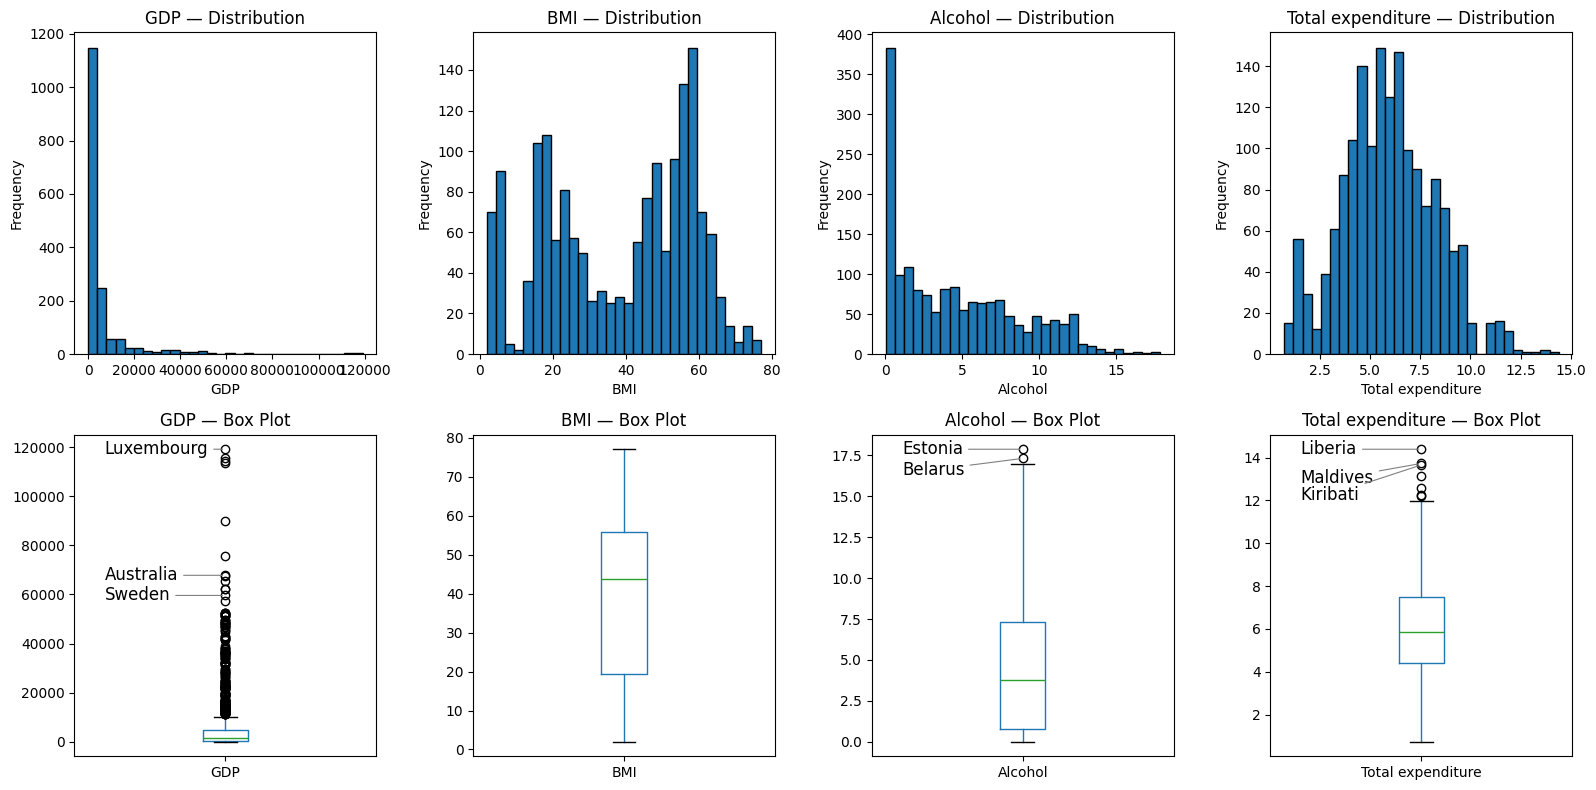

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, col in enumerate(EDA_COLUMNS):
    raw_df[col].hist(bins=30, ax=axes[0, i], edgecolor="black")
    axes[0, i].set_title(f"{col} — Distribution")
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel("Frequency")
    axes[0, i].grid(False)

    raw_df.boxplot(column=col, ax=axes[1, i], grid=False)
    axes[1, i].set_title(f"{col} — Box Plot")

    q1 = raw_df[col].quantile(0.25)
    q3 = raw_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = (
        raw_df[(raw_df[col] < lower_bound) | (raw_df[col] > upper_bound)]
        .sort_values(col, ascending=False)
        .drop_duplicates(subset="Country")
        .head(3)
    )

    for rank, (_, row) in enumerate(outliers.iterrows()):
        axes[1, i].annotate(
            row["Country"],
            xy=(1, row[col]),
            xytext=(0.6, row[col] + rank * -0.7),
            fontsize=12,
            arrowprops=dict(arrowstyle="-", color="gray", lw=0.8),
            va="center",
        )

plt.tight_layout()
plt.savefig("figures/task1_eda.png", dpi=150, bbox_inches="tight")
plt.show()

### Model Development
* Design and implement a DNN-based regression model with Lasso, Ridge, and ElasticNet (combination of Lasso and Ridge) regularization methods
* Optimize the model using the Gradient Descent (GD) algorithm from scratch

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

X = normalized_df.drop(columns=[TARGET_COLUMN]).values
y = normalized_df[TARGET_COLUMN].values.reshape(-1, 1)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 1187, Val: 132, Test: 330


In [17]:
class DNN:
    def __init__(self, layer_sizes: list[int], learning_rate=0.01,
                 regularization="none", reg_lambda=0.001, l1_ratio=0.5):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.l1_ratio = l1_ratio  # for elasticnet: blend between L1 and L2

        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def _relu(self, z):
        return np.maximum(0, z)

    def _relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            self.z_values.append(z)
            self.activations.append(self._relu(z))
        # linear output for regression
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        self.z_values.append(z)
        self.activations.append(z)
        return self.activations[-1]

    def _reg_loss(self):
        if self.regularization == "none":
            return 0.0
        l1 = sum(np.sum(np.abs(w)) for w in self.weights)
        l2 = sum(np.sum(w ** 2) for w in self.weights)
        if self.regularization == "lasso":
            return self.reg_lambda * l1
        elif self.regularization == "ridge":
            return self.reg_lambda * l2
        elif self.regularization == "elasticnet":
            return self.reg_lambda * (self.l1_ratio * l1 + (1 - self.l1_ratio) * l2)
        return 0.0

    def _reg_gradient(self, w):
        if self.regularization == "none":
            return 0.0
        l1_grad = np.sign(w)
        l2_grad = 2 * w
        if self.regularization == "lasso":
            return self.reg_lambda * l1_grad
        elif self.regularization == "ridge":
            return self.reg_lambda * l2_grad
        elif self.regularization == "elasticnet":
            return self.reg_lambda * (self.l1_ratio * l1_grad + (1 - self.l1_ratio) * l2_grad)
        return 0.0

    def backward(self, y):
        n = y.shape[0]
        # output layer gradient (MSE derivative): shape (n, output_size), includes 1/n factor
        delta = (self.activations[-1] - y) * (2 / n)

        self.weight_grads = [None] * len(self.weights)
        self.bias_grads = [None] * len(self.biases)

        for i in reversed(range(len(self.weights))):
            # A^T @ delta sums over n samples; delta already has 1/n, so no extra /n
            self.weight_grads[i] = self.activations[i].T @ delta + self._reg_gradient(self.weights[i])
            # bias gradient is sum over samples (not mean), since delta already has 1/n
            self.bias_grads[i] = np.sum(delta, axis=0, keepdims=True)
            if i > 0:
                delta = (delta @ self.weights[i].T) * self._relu_derivative(self.z_values[i - 1])

    def update_weights(self):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.weight_grads[i]
            self.biases[i] -= self.learning_rate * self.bias_grads[i]

    def compute_loss(self, y_pred, y_true):
        mse = np.mean((y_pred - y_true) ** 2)
        return mse + self._reg_loss()

    def train(self, X_train, y_train, X_val, y_val, epochs=1000, verbose=True):
        self.train_losses = []
        self.val_losses = []

        for epoch in range(epochs):
            y_pred = self.forward(X_train)
            train_loss = self.compute_loss(y_pred, y_train)
            self.backward(y_train)
            self.update_weights()

            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(val_pred, y_val)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            if verbose and (epoch + 1) % 200 == 0:
                print(f"Epoch {epoch + 1:4d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    def predict(self, X):
        return self.forward(X)

In [18]:
ARCHITECTURE = [21, 20, 15, 10, 5, 1]
EPOCHS = 2000
LEARNING_RATE = 0.001
REG_LAMBDA = 0.001

configs = {
    "Lasso (L1)":     {"regularization": "lasso"},
    "Ridge (L2)":     {"regularization": "ridge"},
    "ElasticNet":     {"regularization": "elasticnet", "l1_ratio": 0.5},
}

models = {}
for name, kwargs in configs.items():
    np.random.seed(42)  # identical initialization for fair comparison
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print(f"{'='*50}")
    model = DNN(ARCHITECTURE, learning_rate=LEARNING_RATE,
                reg_lambda=REG_LAMBDA, **kwargs)
    model.train(X_train, y_train, X_val, y_val, epochs=EPOCHS)
    models[name] = model


Training: Lasso (L1)
Epoch  200 | Train Loss: 0.298901 | Val Loss: 0.309295
Epoch  400 | Train Loss: 0.279385 | Val Loss: 0.288570
Epoch  600 | Train Loss: 0.271276 | Val Loss: 0.279605
Epoch  800 | Train Loss: 0.266579 | Val Loss: 0.274113
Epoch 1000 | Train Loss: 0.263340 | Val Loss: 0.270267
Epoch 1200 | Train Loss: 0.260872 | Val Loss: 0.267417
Epoch 1400 | Train Loss: 0.258965 | Val Loss: 0.265083
Epoch 1600 | Train Loss: 0.257475 | Val Loss: 0.263145
Epoch 1800 | Train Loss: 0.256272 | Val Loss: 0.261518
Epoch 2000 | Train Loss: 0.255211 | Val Loss: 0.260129

Training: Ridge (L2)
Epoch  200 | Train Loss: 0.158910 | Val Loss: 0.169291
Epoch  400 | Train Loss: 0.139471 | Val Loss: 0.148641
Epoch  600 | Train Loss: 0.131454 | Val Loss: 0.139753
Epoch  800 | Train Loss: 0.126863 | Val Loss: 0.134363
Epoch 1000 | Train Loss: 0.123721 | Val Loss: 0.130620
Epoch 1200 | Train Loss: 0.121360 | Val Loss: 0.127885
Epoch 1400 | Train Loss: 0.119562 | Val Loss: 0.125652
Epoch 1600 | Train Lo

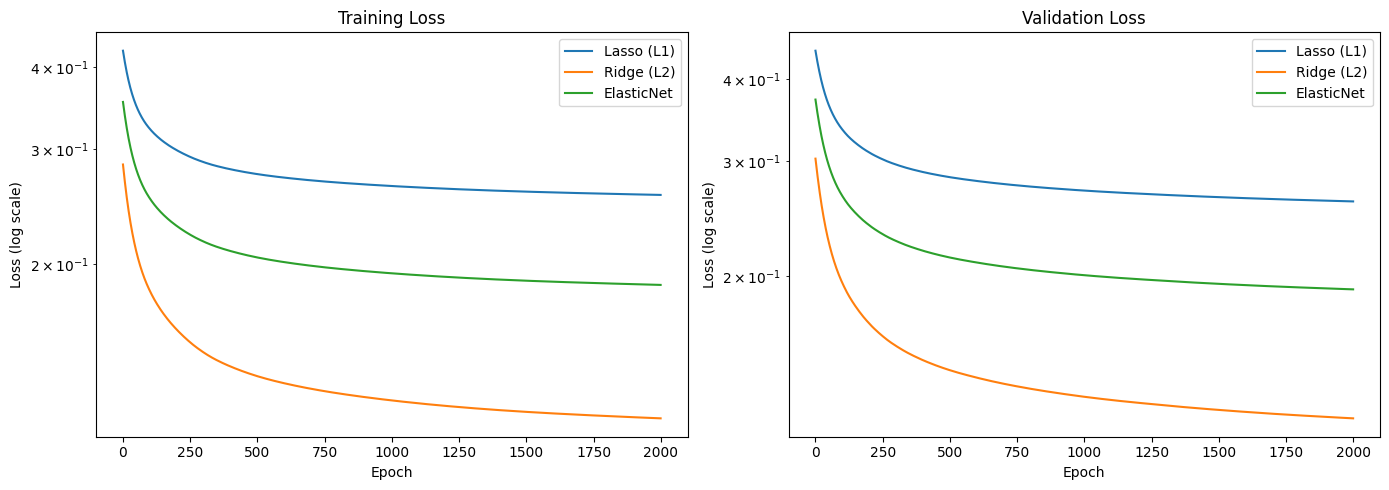

In [19]:
# Overlay all models on one plot
fig, (ax_train, ax_val) = plt.subplots(1, 2, figsize=(14, 5))

for name, model in models.items():
    ax_train.plot(model.train_losses, label=name)
    ax_val.plot(model.val_losses, label=name)

ax_train.set_title("Training Loss")
ax_train.set_xlabel("Epoch")
ax_train.set_ylabel("Loss (log scale)")
ax_train.set_yscale("log")
ax_train.legend()
ax_train.grid(False)

ax_val.set_title("Validation Loss")
ax_val.set_xlabel("Epoch")
ax_val.set_ylabel("Loss (log scale)")
ax_val.set_yscale("log")
ax_val.legend()
ax_val.grid(False)

plt.tight_layout()
plt.savefig("figures/task1_loss.png", dpi=150, bbox_inches="tight")
plt.show()

### Model Evaluation
* Evaluate the trained model using the testing dataset
* Provide visualizations comparing actual values with the predicted regression outputs
* Performance Metrics
  * Mean Squared Error (MSE)
  * Mean Absolute Error (MAE)
  * Root Mean Squared Error (RMSE)
  * R² Score
  * Adjusted R² Score

In [20]:
def compute_metrics(y_true, y_pred, n_features):
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(mse)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    n = len(y_true)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "R²": r2, "Adjusted R²": adjusted_r2}

n_features = X_test.shape[1]
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    results[name] = compute_metrics(y_test, y_pred, n_features)

metrics_df = pd.DataFrame(results).T
metrics_df

,MSE,MAE,RMSE,R²,Adjusted R²
Lasso (L1),0.018194,0.104580,0.134884,0.481262,0.445893
Ridge (L2),0.018201,0.104605,0.134913,0.481038,0.445654
ElasticNet,0.018198,0.104591,0.134901,0.481127,0.445749


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test).flatten()
    y_actual = y_test.flatten()

    ax.scatter(y_actual, y_pred, alpha=0.5, s=15)
    ax.plot([0, 1], [0, 1], "r--", label="Perfect prediction")
    ax.set_title(f"{name} — Actual vs Predicted")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.legend()
    ax.grid(False)

plt.tight_layout()
plt.savefig("figures/task1_scatter.png", dpi=150, bbox_inches="tight")
plt.show()

### Results Analysis

All three regularization variants achieve $R^2 \approx 0.48$, meaning the model explains roughly 48% of the variance in life expectancy on the test set — a moderate result that outperforms a trivial mean predictor. The near-identical performance across Lasso, Ridge, and ElasticNet suggests that at $\lambda = 0.001$ the regularization penalty is too small to meaningfully differentiate the three approaches. The continued downward trend in validation loss at epoch 2,000 indicates the model has not fully converged and would benefit from more epochs or an adaptive optimizer.

### Future Work

Potential improvements to explore:
* More training epochs (e.g., 10,000) or early stopping
* Adaptive optimizer (Adam) instead of batch gradient descent
* Cross-validated hyperparameter search for $\lambda$
* Deeper or wider architecture